In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
# GLOBALS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from tqdm import tqdm
from time import time

# TODO: Move functions to separate modules
import functions as f

import core.background_model as background_model
import core.clique_finding as cf
import core.stats 


TTN_BIN = 4275
BIN_MAP_PATH = 'mappings/bin_map_human_100000.bed'
GTF_PATH = 'mappings/gencode.v38.annotation.gtf'
GENE_BIN_PATH = 'mappings/gene_bins.txt'
NON_GENE_BIN_PATH = 'mappings/non_gene_bins.txt'


gene_bins = []
with open('mappings/gene_bins.txt', 'r') as file:
    for line in file:
        gene_bins.append(line.strip())
gene_bins = [int(x) for x in gene_bins]


non_gene_bins = []
with open('mappings/non_gene_bins.txt', 'r') as file:
    for line in file:
        non_gene_bins.append(line.strip())
non_gene_bins = [int(x) for x in non_gene_bins]



In [4]:
# local 
contact_matrix_zero = np.load('data/hic/wt_100kb_balanced_zeroed.npy')

In [12]:

bin_map_loc = f.load_bin_map_loc('mappings/bin_map_human_100000.bed')

In [15]:
import os

def get_top_n_tf_bins():
    # Load the transcription factor binding sites
    data_dir = 'data/transcription_factors'
  

    # Contains top 1 bin for each TF
    max_bins = []

    # Return counts of transcription factor binding sites in each 100kb bin
    def process_bed_file(file_path):
        bin_counts = {}

        with open(file_path, 'r') as file:
            for line in file:
                if line.startswith('#') or not line.strip():
                    continue
                columns = line.split()
                
                chrom = columns[0]
                start_position = int(columns[1])    
                
                bin_number = f.find_bin(chrom, start_position, bin_map_loc)
                # print(f'Processing {chrom}:{start_position} -> bin {bin_number}')
                
                if bin_number not in bin_counts:
                    bin_counts[bin_number] = 0
                bin_counts[bin_number] += 1

        return bin_counts



    for filename in os.listdir(data_dir):
        # open file

        try:    
            bin_counts = process_bed_file(os.path.join(data_dir, filename))
        except:
            print(f'Error processing {filename}')
            continue

        # get top 20 bins
        top_bin = sorted(bin_counts, key=bin_counts.get, reverse=True)[0]
        max_bins.append(top_bin)

    # write max_bins to file
    with open('mappings/tf_bins.txt', 'w') as file:
        for bin_number in max_bins:
            file.write(f'{bin_number}\n')

    return max_bins
    

tf_bins = get_top_n_tf_bins()


In [5]:

tf_bins = []
with open('mappings/tf_bins.txt', 'r') as file:
    for line in file:
        tf_bins.append(line.strip())
tf_bins = [int(x) for x in tf_bins]

/var/folders/db/z1b_vlyx6z50n353tspswlc80000gn/T/ipykernel_59494/2779991507.py:26: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


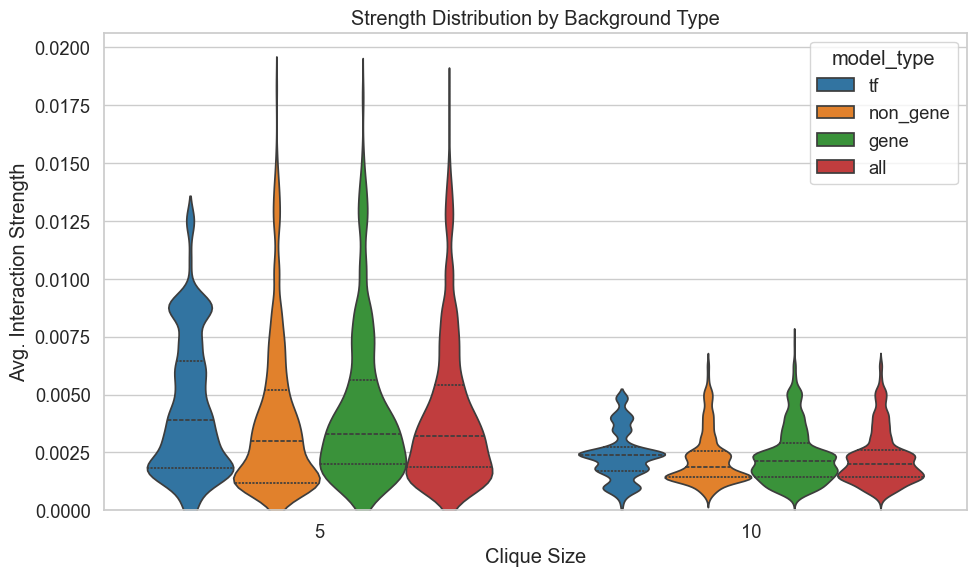

In [26]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv("background_strength_distributions_3.csv")

# Clip top 1% of strength values per group
def clip_outliers(group):
    upper = group["strength"].quantile(0.99)
    return group[group["strength"] <= upper]

df_clipped = df.groupby(["clique_size", "model_type"]).apply(clip_outliers).reset_index(drop=True)

# Define order and color palette
model_order = ["tf", "non_gene", "gene", "all"]
custom_palette = {
    "tf": "#1f77b4",       # blue
    "non_gene": "#ff7f0e", # orange
    "gene": "#2ca02c",     # green
    "all": "#d62728"       # red
}

# Plot
plt.figure(figsize=(10, 6))
sns.violinplot(
    x="clique_size",
    y="strength",
    hue="model_type",
    data=df_clipped,
    inner="quartile",
    scale="width",
    hue_order=model_order,
    palette=custom_palette
)

# Axis labels and title
plt.xlabel("Clique Size")
plt.ylabel("Avg. Interaction Strength")
plt.title("Strength Distribution by Background Type")

# Trim bottom
plt.ylim(0)

plt.tight_layout()
plt.show()

In [11]:
def build_walk_index(contact_matrix):
    """
    Precompute for each node:
      - neighbors[i]: 1D int array of neighbors
      - cdfs[i]:      1D float array of cumulative probabilities
    """
    N = contact_matrix.shape[0]
    neighbors = [None]*N
    cdfs      = [None]*N

    for i in tqdm(range(N)):
        w = contact_matrix[i]
        idx = np.nonzero(w)[0]
        if idx.size == 0:
            neighbors[i] = np.empty(0, dtype=int)
            cdfs[i]      = np.empty(0, dtype=float)
        else:
            probs = w[idx] / w[idx].sum()
            neighbors[i] = idx
            cdfs[i]      = np.cumsum(probs)
    return neighbors, cdfs
neighbors, cdfs = build_walk_index(contact_matrix_zero)

100%|██████████| 30894/30894 [00:20<00:00, 1486.54it/s]


In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm



clique_sizes = [5, 10]
num_samples = 5000
NUM_MOLECULES = 10000   
ALPHA = 0.5
all_bins = [i for i in range(contact_matrix_zero.shape[0])]

records = []


for i in tqdm(range(num_samples)):
    tf_clique = cf.random_walk(contact_matrix_zero, np.random.choice(tf_bins), max(clique_sizes), num_molecules=NUM_MOLECULES, alpha=ALPHA, cdfs=cdfs, neighbors=neighbors)
    non_gene_clique = cf.random_walk(contact_matrix_zero, np.random.choice(non_gene_bins), max(clique_sizes), num_molecules=NUM_MOLECULES, alpha=ALPHA, cdfs=cdfs, neighbors=neighbors)
    gene_clique = cf.random_walk(contact_matrix_zero, np.random.choice(gene_bins), max(clique_sizes), num_molecules=NUM_MOLECULES, alpha=ALPHA, cdfs=cdfs, neighbors=neighbors)
    generic_clique = cf.random_walk(contact_matrix_zero, np.random.choice(all_bins), max(clique_sizes), num_molecules=NUM_MOLECULES, alpha=ALPHA, cdfs=cdfs, neighbors=neighbors)

    for k in clique_sizes:
        tf_strength = core.stats.calculate_avg_interaction_strength(contact_matrix_zero, tf_clique[:k])
        non_gene_strength = core.stats.calculate_avg_interaction_strength(contact_matrix_zero, non_gene_clique[:k])
        gene_strength = core.stats.calculate_avg_interaction_strength(contact_matrix_zero, gene_clique[:k])
        generic_strength = core.stats.calculate_avg_interaction_strength(contact_matrix_zero, generic_clique[:k])

        records.append({"clique_size": k, "model_type": "tf", "strength": tf_strength})
        records.append({"clique_size": k, "model_type": "non_gene", "strength": non_gene_strength})
        records.append({"clique_size": k, "model_type": "gene", "strength": gene_strength})
        records.append({"clique_size": k, "model_type": "all", "strength": generic_strength})

df = pd.DataFrame(records)

# Save to CSV for future reuse
df.to_csv("background_strength_distributions_4.csv", index=False)



plt.figure(figsize=(10, 6)) 
# Optional: Plot
sns.violinplot(x="clique_size", y="strength", hue="model_type", data=df, inner="quartile", scale="width")
plt.xlabel("Clique Size")
plt.ylabel("Avg. Interaction Strength")
plt.title("Strength Distribution by Background Type")
plt.tight_layout()
plt.show()

  0%|          | 2/5000 [00:04<3:03:06,  2.20s/it]


KeyboardInterrupt: 

/var/folders/db/z1b_vlyx6z50n353tspswlc80000gn/T/ipykernel_59494/2540325523.py:26: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


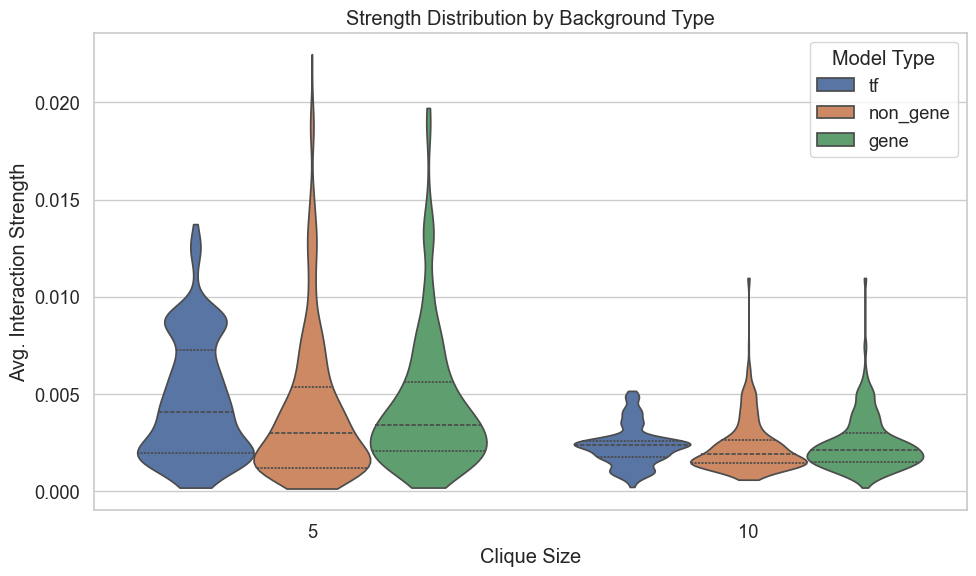

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_background_strength_violin(csv_path: str, title: str = "Strength Distribution by Background Type"):
    """
    Load a CSV containing background model clique strengths and plot a violin plot.
    
    Parameters:
    - csv_path: str, path to the CSV file
    - title: str, optional plot title
    """
    # Load the data
    df = pd.read_csv(csv_path)
    
    # Validate columns
    required_cols = {"clique_size", "model_type", "strength"}
    if not required_cols.issubset(df.columns):
        raise ValueError(f"CSV must contain columns: {required_cols}")

    # Set style
    sns.set(style="whitegrid", font_scale=1.2)

    # Plot
    plt.figure(figsize=(10, 6))
    ax = sns.violinplot(
        x="clique_size", 
        y="strength", 
        hue="model_type", 
        data=df, 
        inner="quartile", 
        scale="width", 
        cut=0
    )
    
    ax.set_xlabel("Clique Size")
    ax.set_ylabel("Avg. Interaction Strength")
    ax.set_title(title)
    plt.legend(title="Model Type", loc="upper right")
    plt.tight_layout()
    plt.show()

plot_background_strength_violin("background_strength_distributions_2.csv", "Strength Distribution by Background Type")